In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import os

np.random.seed(123)

%matplotlib inline
plt.style.use('ggplot')

/home/ponadto/anaconda2/envs/python3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Model regresji liniowej

## $Y \sim \textrm{N} (\mu, \sigma^2)$

## $ \mu = \alpha + \beta_1 X_1 + \beta_2 X_2$

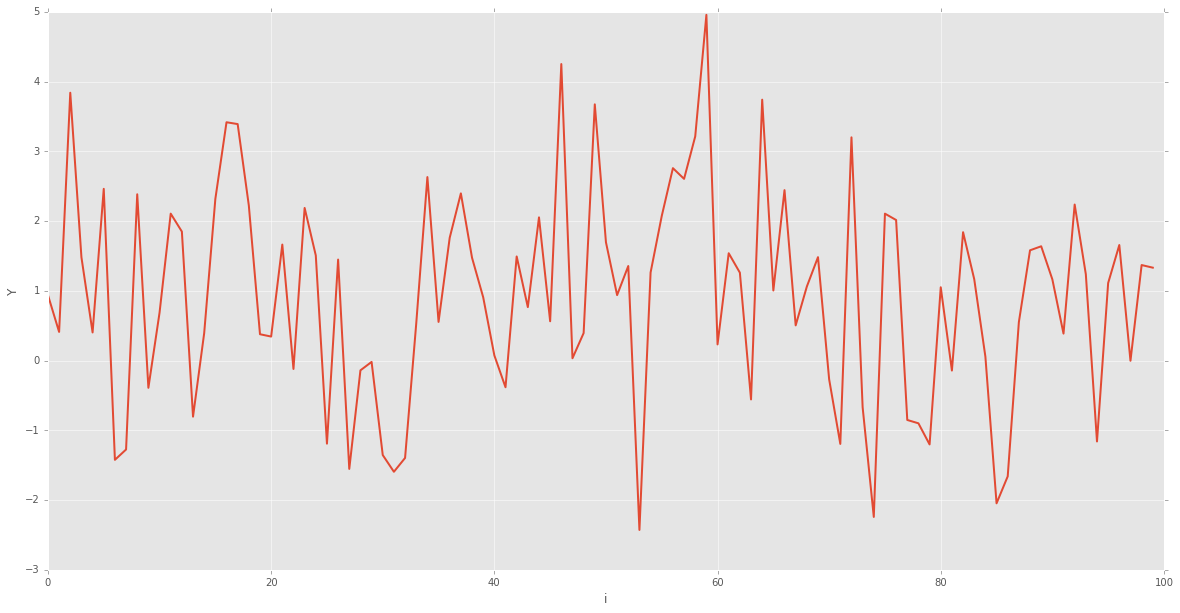

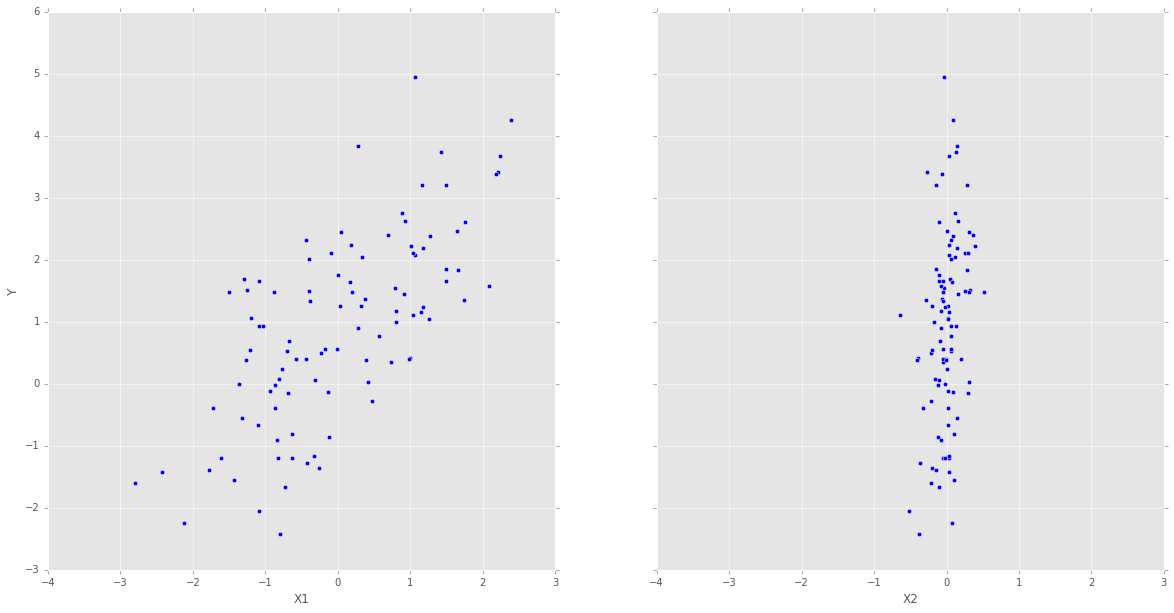

In [2]:
# faktyczne wartosci parametrow
alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

plt.figure(figsize = (20,10))
plt.plot(Y)
plt.xlabel('i')
plt.ylabel('Y')

fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (20, 10))
axes[0].scatter(X1, Y)
axes[0].set_xlabel('X1')
axes[0].set_ylabel('Y')

axes[1].scatter(X2, Y)
axes[1].set_xlabel('X2')

# Definicja modelu

In [19]:
basic_model = pm.Model()

# tworzymy context managera -- wszystko co nastapi w ramach tego bloku 'with'
#  zostanie wziete do tworzenia tego modelu
with basic_model:
    # prajory dla nieznanych parametrow;
    # to sa zmienne losowe o zadanych rozkladach (i definiujacych je parametrach)
    # te parametry (`mu` i `sd`) nosza nazwe "hiperparametry"
    alpha = pm.Normal('alpha', mu = 0, sd = 10)
    beta = pm.Normal('beta', mu = 0, sd = 10, shape = 2) # dostaniemy dwu-elementowa liste bet
    sigma = pm.HalfNormal('sigma', sd = 1)
    
    # wartosc oczekiwana zmiennej objasniajacej (jest to zmienna losowa, zauwaz)
    mu = alpha + beta[0]*X1 + beta[1]*X2
    # zauwaz, ze jest to model DETERMINISTYCZNY, nie ma tu zadnego elementu losowego (poza tym, ktory siedzi w X1, X2 i betach)
    
    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = Y)
    # tego typu zmienna nosi nazwe "observed stochastic";
    # zauwaz, ze parametry tego rozkladu (mu i sigma) sa zdefiniowanymi wczesniej zmiennymi losowymi 

Applied log-transform to sigma and added transformed sigma_log to model.


# Fitowanie modelu

## zwykły MAP

In [20]:
map_estimate = pm.find_MAP(model = basic_model, fmin = sc.optimize.fmin_powell)

print(map_estimate)

{'Y_sim': array([ 0.21305608,  0.8186227 ,  1.54740956,  0.83671444,  0.34533216,
        2.49047321, -1.30021497, -0.47310666,  2.3298559 , -0.75413112,
        0.03957297,  1.46664519,  1.93658669,  0.56302677,  1.01519266,
        0.64066984,  2.28179164,  2.80644068,  2.88297407,  0.21449941,
        1.46179725,  2.03167254,  0.08260417,  2.41276271,  0.55878075,
        0.16087128,  2.19148842, -0.18659557,  1.02193742, -0.20502887,
        0.14314939, -2.32167513, -1.16826579,  0.41135706,  2.18392817,
        0.91124789,  0.62257194,  2.50331438,  0.8667668 ,  0.99069781,
       -0.28720608, -0.66323116,  1.19857885,  1.62479833,  1.51874575,
        0.78473789,  3.41363237,  2.10563212,  1.70952946,  3.10382286,
       -0.18752019,  0.07017449,  1.82213767, -0.83090307,  0.40198729,
        2.00846795,  2.04083194,  2.29333508,  3.04479191,  1.84592207,
        0.18477776,  1.55907834,  1.274841  ,  0.01752266,  2.59855952,
        1.20259642,  1.74634441,  0.11343929, -0.18795

## za pomocą MCMC (a konkretniej, algorytmu NUTS)

In [21]:
N = 10000

with basic_model:
    
    # najpierw znajdujemy porzadne parametry poczatkowe, korzystajac ze zwyklego MAPa
    start = pm.find_MAP(fmin = sc.optimize.fmin_powell)
    # zauwaz, ze jako pierwszy argument (model) zostal przekazany `basic_model`
    
    # ciagniemy N probek a posteriori
    trace = pm.sample(N, start = start)

Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log_
Assigned NUTS to Y_sim
 [-----------------100%-----------------] 10000 of 10000 complete in 16.7 sec

# Wykresy wyników (zmienna `trace`)

/home/ponadto/anaconda2/envs/python3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 10 x 100)
  '(shape is %d x %d)' % inp.shape[::-1])


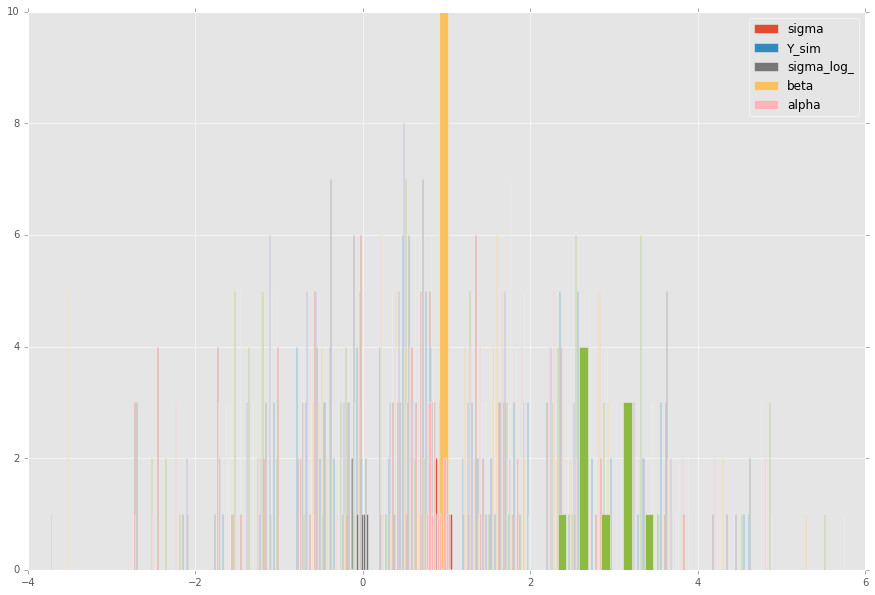

In [22]:
plt.figure(figsize = (15,10))
for parameter_key in trace[0].keys():
    plt.hist(trace[parameter_key][-10:], label = parameter_key)

plt.legend()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b6b3a8c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9b6b8bfef0>]], dtype=object)

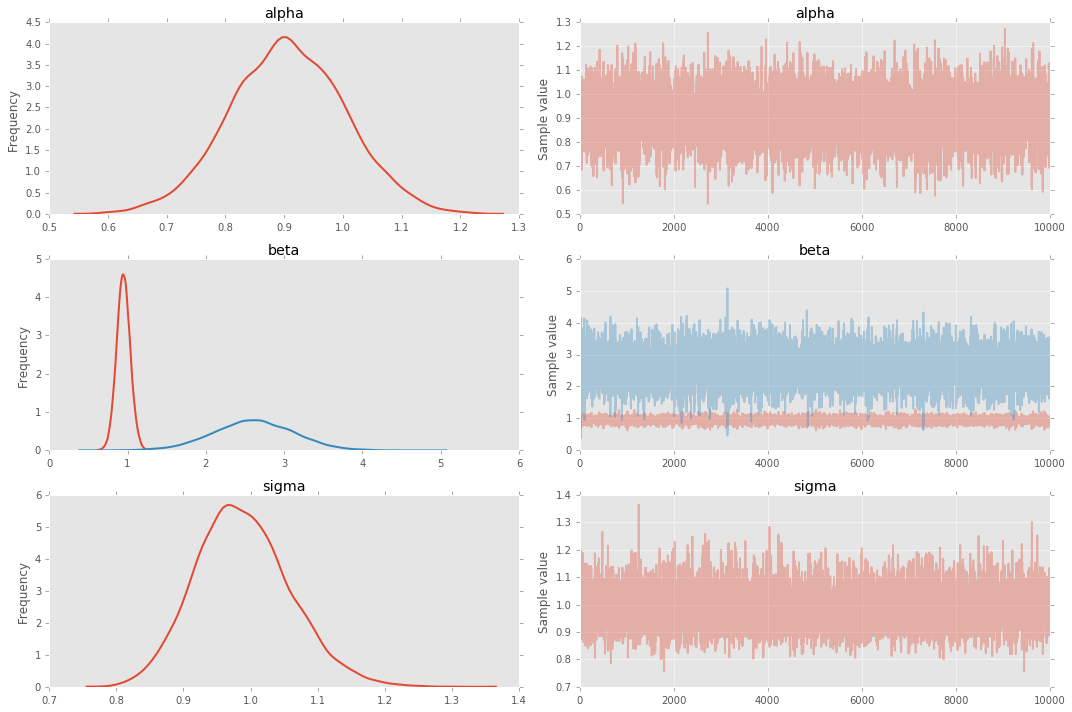

In [8]:
pm.traceplot(trace, figsize = (15, 10))

# Podsumowanie przy użyciu `summary`

In [9]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.906            0.098            0.001            [0.712, 1.099]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.713          0.839          0.905          0.972          1.100


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.947            0.087            0.001            [0.778, 1.124]
  2.608            0.513            0.004            [1.581, 3.593]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.776          0.890          0.947          1.005          1.122
  1.590          2.269          2.609   

## a jakby to wygladalo, gdybysmy wzieli 2x wiecej probek z MCMC?

In [10]:
with basic_model:
    
    # najpierw znajdujemy porzadne parametry poczatkowe, korzystajac ze zwyklego MAPa
    start = pm.find_MAP(fmin = sc.optimize.fmin_powell)
    # zauwaz, ze jako pierwszy argument (model) zostal przekazany `basic_model`
    
    # ciagniemy N probek a posteriori
    trace = pm.sample(2*N, start = start)

pm.summary(trace)

Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log_
 [-----------------100%-----------------] 20000 of 20000 complete in 14.6 sec
alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.907            0.098            0.001            [0.709, 1.096]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.713          0.841          0.906          0.972          1.100


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.948            0.088            0.000            [0.780, 1.123]
  2.608            0.508            0.003            [1.612, 3.615]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|=======

# Predykcja

In [42]:
import theano


alpha, sigma = 1, 1
beta = [1, 2.5]

size = 1000

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# TU JEST COS NOWEGO ###################
X1_shared = theano.shared(X1)
X2_shared = theano.shared(X2)
########################################

Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

# NA TYM BEDZIEMY PREDYKOWAC: #######################################################
X1_new = np.random.randn(size)
X2_new = np.random.randn(size) * 0.2
# A TO BEDZIEMY PROBOWALI ODTWORZYC
Y_new = alpha + beta[0]*X1_new + beta[1]*X2_new + np.random.randn(size)*sigma
######################################################################################

N = 10000

predictive_model = pm.Model()


# tworzymy context managera -- wszystko co nastapi w ramach tego bloku 'with'
#  zostanie wziete do tworzenia tego modelu
with predictive_model:
    # prajory dla nieznanych parametrow;
    # to sa zmienne losowe o zadanych rozkladach (i definiujacych je parametrach)
    # te parametry (`mu` i `sd`) nosza nazwe "hiperparametry"
    alpha = pm.Normal('alpha', mu = 0, sd = 10)
    beta = pm.Normal('beta', mu = 0, sd = 10, shape = 2) # dostaniemy dwu-elementowa liste bet
    sigma = pm.HalfNormal('sigma', sd = 1)
    
    # wartosc oczekiwana zmiennej objasniajacej (jest to zmienna losowa, zauwaz)
    mu = alpha + beta[0]*X1_shared + beta[1]*X2_shared
    # zauwaz, ze jest to model DETERMINISTYCZNY, nie ma tu zadnego elementu losowego (poza tym, ktory siedzi w X1, X2 i betach)
    
    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = Y)
    # tego typu zmienna nosi nazwe "observed stochastic";
    # zauwaz, ze parametry tego rozkladu (mu i sigma) sa zdefiniowanymi wczesniej zmiennymi losowymi 
    
    # najpierw znajdujemy porzadne parametry poczatkowe, korzystajac ze zwyklego MAPa
    start = pm.find_MAP(fmin = sc.optimize.fmin_powell)
    # zauwaz, ze jako pierwszy argument (model) zostal przekazany `basic_model`
    
    # ciagniemy N probek a posteriori
    trace = pm.sample(N, start = start)
    



Applied log-transform to sigma and added transformed sigma_log to model.
Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log_
 [-----------------100%-----------------] 10000 of 10000 complete in 8.6 sec

In [43]:
X1_shared.set_value(X1_new)
X2_shared.set_value(X2_new)

ppc = pm.sample_ppc(trace, model = predictive_model, samples = 500)

(-4, 6)

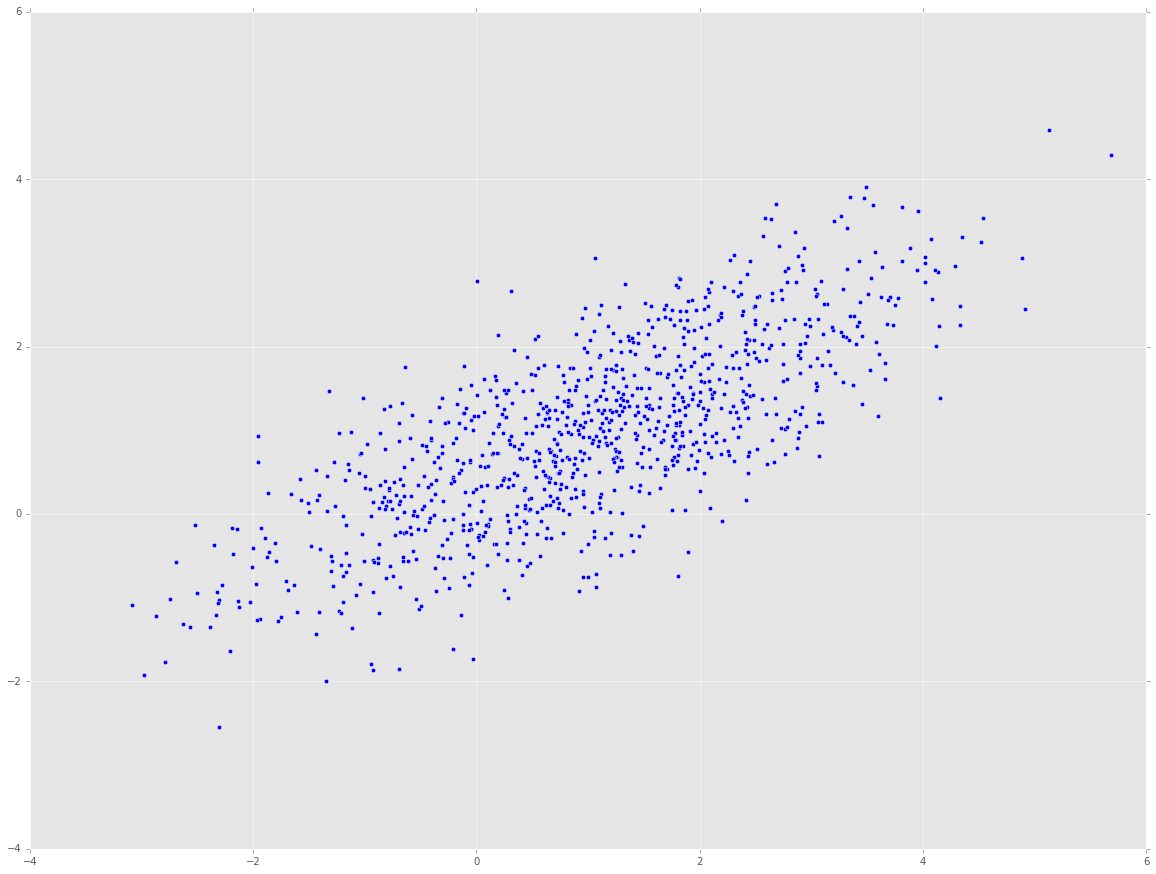

In [44]:
plt.figure(figsize = (20,15))
plt.scatter(Y_new, np.asarray(ppc['Y_obs']).mean(axis = 0))
plt.xlim((-4,6))
plt.ylim((-4,6))

# Case study 1: Stochastic volatility

## Model:

### $\sigma \sim \exp(50) $                               (`Exponential`)

### $\nu \sim \exp(.1)$                                       (`Exponential`)

### $s_i \sim \aleph(s_{i-1}, \sigma^{-2})$ (`GaussianRandomWalk`)

### $\log(y_i) \sim t(\nu, 0, \exp(-2s_i))$ (`StudentT`)

3813


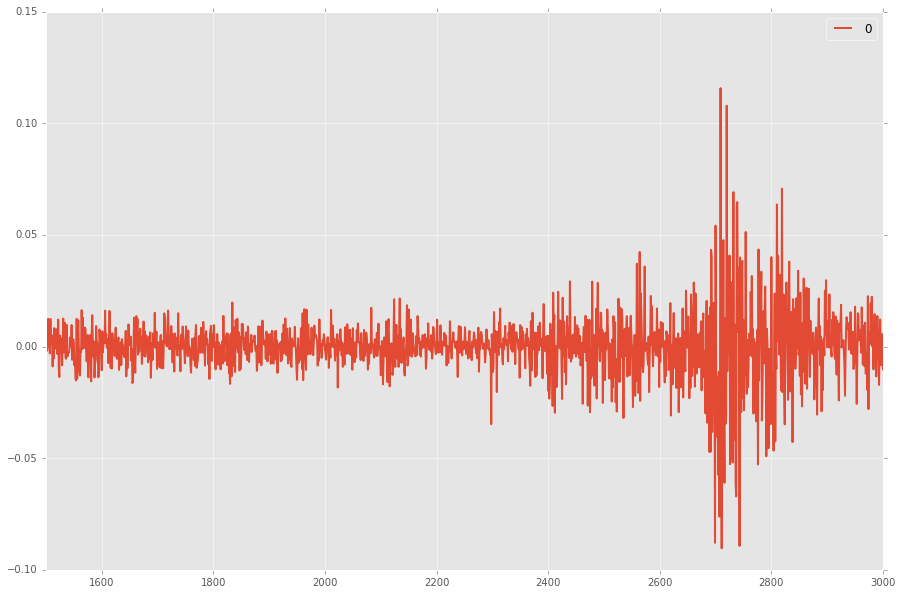

In [11]:
if os.path.isfile('SP500.csv'):
    returns = pd.read_csv('SP500.csv', parse_dates=True, header = None)
print(len(returns))
returns = returns.loc[1500:3000,]

returns.plot( figsize = (15,10) )

In [12]:
with pm.Model() as sp500_model:

    # zmienna rzadzaca stopniem swobody w rozkladzie t-Studenta
    nu = pm.Exponential('nu', 1./10, testval = 5.)
    # `testval` to (opcjonalna) wartosc poczatkowa 

    # zmienna rzadzaca tym calym "volatility process"
    sigma = pm.Exponential('sigma', 1./.02, testval = .1)

    # random walk o dlugosci `shape`
    s = pm.distributions.timeseries.GaussianRandomWalk('s', sigma**-2, shape = len(returns))

    # zwroc uwage, ze wzielismy `pm.exp` zamiast `np.exp` (`pm.exp` pochodzi z modulu theano)
    volatility_process = pm.Deterministic('volatility_process', pm.exp(-2*s))

    r = pm.StudentT('r', nu, lam = 1/volatility_process, observed = returns[0])

Applied log-transform to nu and added transformed nu_log to model.
Applied log-transform to sigma and added transformed sigma_log to model.


In [13]:
N = 2000

with sp500_model:
    
    # korzystamy z "Limited-memory BFGS (L-BFGS)", ktory jest lepszy dla wielowymiarowych funkcji,
    # a my mamy ich wszak blisko 3600 (glownie pochodza z `s`)
    start = pm.find_MAP(vars = [s], fmin = sc.optimize.fmin_l_bfgs_b)

    step = pm.NUTS(scaling = start)
    trace = pm.sample(100, step, progressbar = True)

    # Start next run at the last sampled position.
    step = pm.NUTS(scaling = trace[-1], gamma = .25)
    trace = pm.sample(N, step, start = trace[-1], progressbar = True)

 [-----------------100%-----------------] 2000 of 2000 complete in 464.8 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b68e62cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9b42455048>]], dtype=object)

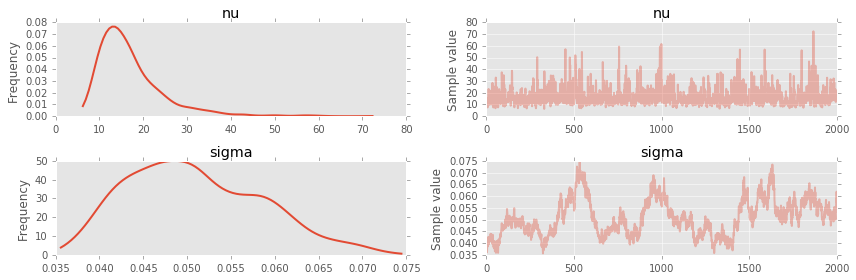

In [14]:
pm.traceplot(trace, [nu, sigma])

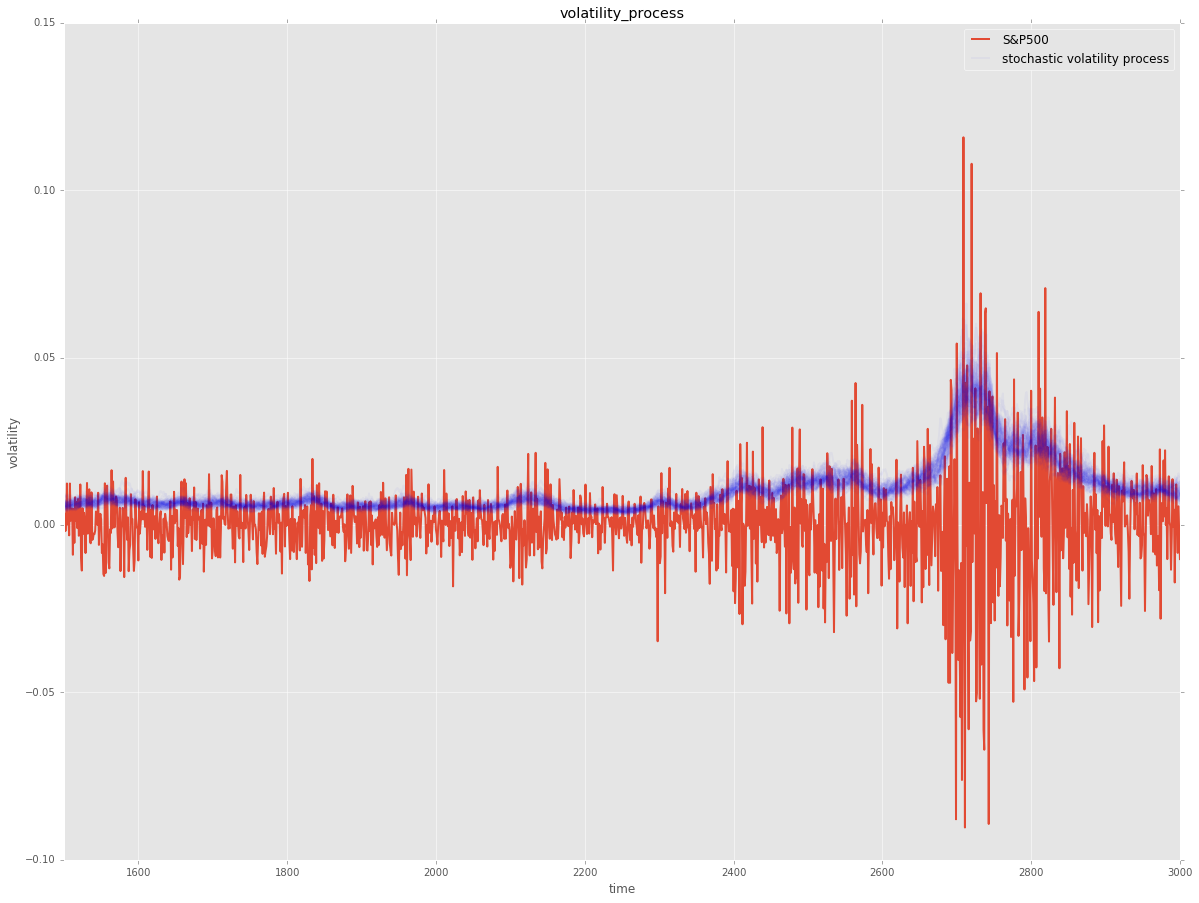

In [15]:
fig, ax = plt.subplots(figsize = (20, 15))
returns.plot(ax = ax)
ax.plot(returns.index, 1/np.exp(trace['s',::30].T), 'b', alpha = .03);
ax.set(title = 'volatility_process', xlabel = 'time', ylabel = 'volatility');
ax.legend(['S&P500', 'stochastic volatility process'])

In [17]:
trace['s',::30].T

array([[ 5.09273455,  5.23267125,  4.68727235, ...,  4.95754142,
         5.25840069,  5.33715612],
       [ 5.01925331,  5.24223779,  4.67799216, ...,  4.96556224,
         5.12972719,  5.25970785],
       [ 4.99281893,  5.19264374,  4.70119977, ...,  4.95393416,
         5.11937237,  5.22709449],
       ..., 
       [ 4.5445097 ,  4.72816913,  4.63856494, ...,  4.63480276,
         4.45895599,  4.51322294],
       [ 4.52778029,  4.70612695,  4.6940714 , ...,  4.69842679,
         4.52713315,  4.5495481 ],
       [ 4.4970834 ,  4.67118145,  4.70517096, ...,  4.70784132,
         4.58859343,  4.56179204]])

In [18]:
trace[0]

{'nu': 14.428774446687516,
 'nu_log_': 2.6692244382494579,
 's': array([ 5.30334957,  5.2785378 ,  5.33765188, ...,  4.58974843,
         4.67030071,  4.62548649]),
 'sigma': 0.037522006657899364,
 'sigma_log_': -3.2828276739208486,
 'volatility_process': array([  2.47496517e-05,   2.60088005e-05,   2.31086453e-05, ...,
          1.03132409e-04,   8.77866230e-05,   9.60181822e-05])}

In [ ]:
returns[0].sum()

# Case study 2: Coal mining disasters

In [ ]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize = 8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

In [ ]:
help(np.ma)